# Improving Chest X-ray Pneumonia Detection with Federated Learning and Covalent

![alt text](assets/hero.png "Covalent")

In this tutorial, we will provide a comprehensive guide on federated learning, dive into the technical aspects required for building Covalent workflows, and showcase how the two can be combined to build powerful experiments. The exemplar case we will employ involves the identification of pneumonia from chest X-rays.

This tutorial requires PyTorch, Hugging Face Transformers and Covalent plugins. To install all of them, simply use the requirements.txt file to replicate this notebook

In [27]:
with open("./requirements.txt", "r") as file:
    for line in file:
        print(line.rstrip())

covalent==0.220.0
covalent-awsbatch-plugin==0.26.0
covalent-azurebatch-plugin==0.12.0
covalent-gcpbatch-plugin==0.9.0
datasets==2.14.0
torch==2.0.1
torchvision==0.15.2
pandas
plotly


In [28]:
# Uncomment below line to install necessary libraries
# !pip install -r requirements.txt

# Federated Learning on Pneumonia Chest X-rays
In our demonstration of federated learning, we will train three separate Convolutional Neural Networks (CNNs) using distinct Pneumonia Chest X-ray datasets. Subsequently, the trained models and their corresponding weights will be transmitted back to a central node. On this central node, we will perform weight aggregation using a simple weighted arithmetic mean:

$$
\begin{equation}
w_{j} = \sum_{k=1}^{K} \frac{w_{jk} d_k}{\sum_{i=1}^{K}d_i}
\tag{1}
\end{equation}
$$

Here, $w_j$ represents the set of weights in CNN layer $j$, $K$ is the number of models/datasets, which in our case is three, and $d_k$ represents the size of the dataset $k$.

This federated learning variant is commonly called [centralized federated learning](https://en.wikipedia.org/wiki/Federated_learning#Centralized_federated_learning), where a single central node oversees the entire learning process. Utilizing weight averaging represents just one approach among several options available in federated learning. Other alternatives include exchanging gradients instead of weights or implementing techniques such as dynamic regularization.

Broadly speaking, our federated learning workflow encompasses the subsequent stages:

1. Training autonomous CNN models in isolation.
2. Consolidating the distinct CNN models into a singular aggregated model.
3. Iteratively revisiting steps 1-2, this time refining the autonomous models by fine-tuning the aggregated model. 

We execute the workflow for a predefined number of rounds. Each round entails training separate CNN models on isolated nodes without sharing any data. Subsequently, we aggregate the models, and evaluation is performed on each individual test set. Throughout the process, the centralized node solely possesses information about the model weights, dataset size, and accuracy scores.

For datasets, we will utilize three datasets currently available in the 🤗 Hugging Face Datasets repository:

- [chest-xray-classification](https://huggingface.co/datasets/keremberke/chest-xray-classification)
- [raw_pneumonia_x_ray](https://huggingface.co/datasets/mmenendezg/raw_pneumonia_x_ray)
- [NIH-Chest-X-ray-dataset](https://huggingface.co/datasets/alkzar90/NIH-Chest-X-ray-dataset)


In [29]:
import covalent as ct

import os
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
from torch import nn
import numpy as np
import pandas as pd
import torch
from dataclasses import dataclass
from typing import Tuple, Callable, Dict
import pickle

from collections import Counter


@dataclass
class HFDataset:
    """
    A class to represent a dataset available
    in the Hugging Face repository.
    """
    name: Tuple[str, str]
    cloud_provider: str
    filter_func: Callable[[Dict[str, str]], bool] = None
    transform_label_func: Callable[[Dict[str, str]], int] = None

In [30]:
# !pip install covalent-awsbatch-plugin covalent-gcpbatch-plugin covalent-azurebatch-plugin

We define parameters for three different executor types, one for each cloud. Each respective cloud instance will handle a single data source, ensuring data isolation as our approach to data separation. The association between a cloud and a dataset will be defined at runtime. 

In [41]:
AWS_EXECUTOR_DEFAULT_PARAMS = {
    "vcpu": 2,
    "memory": 4,
    "num_gpus": 0,
    "retry_attempts": 1,
    "time_limit": 3000,
    "poll_freq": 3
}
GCP_EXECUTOR_DEFAULT_PARAMS = {
    "vcpus": 4,
    "memory": 4096,
    "time_limit": 3000,
    "poll_freq": 3,
    "retries": 1
}
AZURE_EXECUTOR_DEFAULT_PARAMS = {
    "pool_id": "default",
    "retries": 1,
    "time_limit": 3000,
    "cache_dir": "/tmp/covalent",
    "poll_freq": 3
}

Our stub workflow signature suggests we run federated learning for a specified number of rounds on specified datasets. 

In [42]:
@ct.lattice
def federated_learning_workflow(
    datasets: HFDataset, round_number, epoch_per_round, batch_size,
    model_agg=None, image_dimension=64,
):
    ...

Once a lattice is defined, you must dispatch a workflow to run it. You can dispatch a lattice workflow using Covalent by calling `ct.dispatch` and providing a workflow name and parameters.

In [43]:
def filter_by_label(example, sample_size=1000):
    if 0 not in example['labels'] and 7 not in example['labels']:
        return False
    else:
        label = 0 if 0 in example['labels'] else 1

    if filter_by_label.label_freq[label] >= sample_size:
        return False
    else:
        filter_by_label.label_freq[label] += 1

    return True


def map_labels_to_single_label(labels):
    if 0 in labels:
        return 0
    else:
        return 1


hf_datasets = [
    HFDataset(
        name=("keremberke/chest-xray-classification", 'full'),
        cloud_provider='aws',
    ),
    HFDataset(
        name=("mmenendezg/raw_pneumonia_x_ray", ),
        cloud_provider="gcp",
    ),
    HFDataset(
        name=(
            "alkzar90/NIH-Chest-X-ray-dataset",
            "image-classification"
        ),
        cloud_provider='azure',
        filter_func=filter_by_label,
        transform_label_func=map_labels_to_single_label
    )
]

dispatch_id = ct.dispatch(federated_learning_workflow)(
    hf_datasets, round_number=50,
    epoch_per_round=1, batch_size=32
)

The diagram below portrays the overarching design of a Covalent workflow example that spans AWS, GCP, and Azure environments.

![alt text](assets/architecture.png "Covalent")

# Pneumonia Chest X-ray Federated Learning using Covalent

We now demonstrate how to utilize Covalent to run and perform federated learning across several cloud providers. To achieve this, we establish a dynamic [sublattice](https://docs.covalent.xyz/docs/user-documentation/concepts/covalent-basics/#sublattice), which creates an executor at runtime. This approach allows us to allocate cloud resources on the fly, based on the workflow's input parameters.

In [44]:
@ct.electron
@ct.lattice
def cloud_pnemonia_classifier(cloud_provider, use_gpu=False, **kwargs):
    # Match provider to an executor.
    cloud_service_executor_mapping = {
        "aws": ct.executor.AWSBatchExecutor(**AWS_EXECUTOR_DEFAULT_PARAMS),
        "gcp": ct.executor.GCPBatchExecutor(**GCP_EXECUTOR_DEFAULT_PARAMS),
        "azure": ct.executor.AzureBatchExecutor(**AZURE_EXECUTOR_DEFAULT_PARAMS),
    }

    # Create a new electron (task) that uses this executor.
    electron = ct.electron(
        build_pneumonia_classifier,
        executor=cloud_service_executor_mapping.get(cloud_provider),
        deps_pip=ct.DepsPip(
            packages=[
                "torch==2.0.1", "torchvision==0.15.2","datasets==2.14.0"
            ]
        )
    )
    return electron(**kwargs)

It is important to observe that in this case `build_pneumonia_classifier` is built as an `ct.electron` object dynamically at runtime, which is also when an executor is assigned.

Executor default configuration parameters are available in the Covalent config (typically located at `$HOME/.config/covalent/covalent.conf`).  More information on running batch executors is available in the Covalent docs for [AWSBatch](https://docs.covalent.xyz/docs/user-documentation/api-reference/executors/awsbatch/), [AzureBatch](https://docs.covalent.xyz/docs/user-documentation/api-reference/executors/azurebatch/), and [GCPBatch](https://docs.covalent.xyz/docs/user-documentation/gcp/). Python framework prerequisite dependencies installed on cloud resources are specified using `ct.DepsPip`.
With the main `@ct.lattice` defined, let's delve into the specifics of the `build_pneumonia_classifier method`. Its primary tasks include:
1. Loading and preprocessing the dataset,
2. Creating a new model or continuing the training of a previously trained supervised model, and
3. Evaluating the performance of the model on the loaded test dataset.

First, we define the convolutional neural network architecture. 

In [45]:
class PneumoniaDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        return item['image'], item['label']


class PneumoniaNet(nn.Module):
    """
    Simple CNN for pneumonia detection.
    """
    def __init__(self, image_dim=64):
        super(PneumoniaNet, self).__init__()
        # channel number is 1 for grayscale images
        # use 3 for RGB images
        channel_number = 1
        self.image_dim = image_dim

        self.conv1 = nn.Conv2d(
            in_channels=channel_number, out_channels=16, kernel_size=3,
            stride=1, padding=1
        )
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3,
            stride=1, padding=1
        )
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(
            kernel_size=2, stride=2
        )

        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3,
            stride=1, padding=1
        )
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3,
            stride=1, padding=1
        )
        self.relu4 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(
            kernel_size=2, stride=2
        )
        mapping = {
            64: 32768,
            128: 131072
        }
        self.fc1 = nn.Linear(mapping[self.image_dim], 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.batchnorm1(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.batchnorm2(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output


@ct.electron
def create_pneumonia_network(
    image_dimension
):
    return PneumoniaNet(image_dimension)

Next, we write the methods to prepare the dataset, train, and evaluate the models. 

In [46]:
@ct.electron
def prepare_dataset(
    dataset_name, filter_func=None, transform_label=None,
    image_dimension=64, client=None
):
    ds_name_path = dataset_name[0].replace('/', '-')
    save_path = f'preprocessed-obj-{ds_name_path}'

    exists_on_cloud = client.check_file_exists(
        save_path
    ) if client is not None else False

    if os.path.exists(save_path):
        print('Loading preprocessed data from local')
        with open(save_path, 'rb') as f:
            preprocessed_train, preprocesed_test, maj_test_acc = pickle.load(f)
    elif not os.path.exists(save_path) and exists_on_cloud:
        print('Loading preprocessed data from cloud')
        client.download_file(
            save_path, save_path
        )
        with open(save_path, 'rb') as f:
            preprocessed_train, preprocesed_test, maj_test_acc = pickle.load(f)
    else:
        print('Preprocessing data')
        dataset = load_dataset(
            *dataset_name,
        )
        image_mean = [0.5]
        image_std = [0.5]
        image_transformation = transforms.Compose([
            transforms.Resize(
                size=(image_dimension, image_dimension)
            ),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=image_mean, std=image_std
            )
        ])
        preprocessed_train, label_column = preprocess(
            dataset['train'], image_transformation,
            transform_label_func=transform_label,
            filter_func=filter_func
        )
        preprocesed_test, label_column = preprocess(
            dataset['test'], image_transformation,
            transform_label_func=transform_label,
            filter_func=filter_func
        )

        labels = np.array(
            [x['label'] for x in preprocesed_test]
        )
        maj_test_acc = get_majority_class_accuracy(labels)
        preprocessed_data = (
            preprocessed_train, preprocesed_test, maj_test_acc
        )
        with open(save_path, "wb") as f:
            pickle.dump(preprocessed_data, f)

        # upload to cloud
        if client is not None:
            client.upload_file(save_path, save_path)

    train_ds = PneumoniaDataset(preprocessed_train)
    test_ds = PneumoniaDataset(preprocesed_test)

    return train_ds, test_ds, maj_test_acc


@ct.electron
def train_model(
    model, epoch_count, train_dataloader, use_gpu=False
):
    print("Training model")
    ds_size = len(train_dataloader.dataset)
    losses = []
    optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
    criterion = nn.BCELoss()

    for epoch in range(epoch_count):
        if use_gpu:
            model = model.cuda()
        model.train()
        running_loss = 0
        train_correct = 0

        for images, labels in train_dataloader:
            labels = labels.float()
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            output = model(images).flatten()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss)
            running_loss += loss.item()

            # Calculate training accuracy
            predicted = (output > 0.5).long()
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / ds_size
        print("Epoch {} - Training loss: {:.4f} - Accuracy: {:.4f}".format(
            epoch + 1, running_loss / len(train_dataloader), train_acc)
        )
        if use_gpu:
            # detach from GPU after finishing training
            model = model.cpu()

    return losses, ds_size


@ct.electron
def evaluate(
    model, test_dataloader, use_gpu=False
):
    if use_gpu:
        model = model.cuda()

    criterion = nn.BCELoss()
    model.eval()
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            labels = labels.float()
            if use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            output = model(images).flatten()
            loss = criterion(output, labels)
            test_loss += loss.item()

            predicted = (output > 0.5).long()
            test_correct += (predicted == labels).sum().item()

        test_acc = test_correct / len(test_dataloader.dataset)
        print(
            "Test loss: {:.4f} - Test accuracy: {:.4f}".format(
                test_loss / len(test_dataloader), test_acc
            )
        )

    # detach from GPU after evaluation
    if use_gpu:
        model = model.cpu()

    return test_acc, test_loss

We put everything together in a single method that encompasses all the past steps and builds a pnemonia classifier. 

In [47]:
def build_pneumonia_classifier(
    dataset_name=None, filter_func=None, transform_label=None,
    model=None, epoch_number=2, batch_size=64,
    image_dimension=64
):
    train_ds, test_ds, maj_test_acc = prepare_dataset(
        dataset_name, filter_func, transform_label,
        image_dimension=image_dimension
    )
    train_dataloader, test_dataloader = create_dataloaders(
        train_ds, test_ds, batch_size
    )

    if not model:
        model = create_pneumonia_network(image_dimension)

    train_losses, ds_size = train_model(
        model, epoch_number, train_dataloader
    )
    test_acc, test_loss = evaluate(model, test_dataloader)
    return model, ds_size, test_acc

Lastly, to finalize our federated learning workflow, we showcase the process of constructing an aggregated model from the individual models through weighted averaging, as defined in equation $(1)$.

In [48]:
import torch

@ct.electron
def create_aggregated_network(
    model_list, ds_sizes, image_dimension=64
):
    """
    Simple aggregation mechanism where weights of a network
	  are aggregated using a weighted average, where the value of the
    weight is the size of the dataset
    """
    dataset_weights = np.array(ds_sizes) / sum(ds_sizes)
    whole_aggregator = []

    # compute a weighted average
    for p_index, layer in enumerate(model_list[0].parameters()):
        params_aggregator = torch.zeros(layer.size())

        for model_index, model in enumerate(model_list):
            params_aggregator = params_aggregator + dataset_weights[
                model_index
            ] * list(model.parameters())[p_index].data
        whole_aggregator.append(params_aggregator)

    net_avg = create_pneumonia_network(image_dimension)

    for param_index, layer in enumerate(net_avg.parameters()):
        layer.data = whole_aggregator[param_index]
    return net_avg

Now we expand on the previously introduced `federated_learning_workflow`,  which interconnects all the tasks (electrons) into a main workflow (lattice). This workflow facilitates the creation of a pnemonia classifier for each dataset, ensuring seamless development within isolated cloud environments. After the models are crafted, they are transmitted back to the central node. Here, the resulting models are aggregated as described in `create_aggregated_network`, thereby producing a refined model for the isolated cloud environments to further enhance and improve upon.

In [49]:
@ct.lattice
def federated_learning_workflow(
    datasets: HFDataset, round_number, epoch_per_round, batch_size,
    model_agg=None, image_dimension=64, use_gpu=False
):
    test_accuracies = []
    model_showcases = []
    for round_idx in range(round_number):
        print(f"Round {round_idx + 1}")
        models = []
        dataset_sizes = []
        for ds in datasets:
            trained_model, ds_size, test_accuracy = cloud_pnemonia_classifier(
                ds.cloud_provider,
                dataset_name=ds.name, model=model_agg,
                image_dimension=image_dimension,
                epoch_number=epoch_per_round,
                transform_label=ds.transform_label_func,
                filter_func=ds.filter_func, use_gpu=use_gpu
            )
            models.append(trained_model)
            dataset_sizes.append(ds_size)
            test_accuracies.append(
                (round_idx + 1, ds.name, test_accuracy)
            )
            if round_idx == round_number - 1:
                model_showcases.append((trained_model, ds.name))

        model_agg = create_aggregated_network(
            models, dataset_sizes, image_dimension=image_dimension,
        )
        if round_idx == round_number - 1:
            model_showcases.append((model_agg, "aggregated"))

    return test_accuracies, model_showcases

The iterative process of centralized federated learning continues for a duration determined by the `round_number` hyper-parameter. The illustration below provides a visual depiction of how the Covalent UI presents the aforementioned workflow when `round_number` is set to 2, and the workflow encompasses the processing of three distinct datasets across three different cloud providers.

![alt text](assets/workflow.gif "Covalent")

# Evaluation of applying Federated Learning to X-ray data
In this evaluation, we aim to shed further light on the intrinsic advantages of federated learning, particularly its emphasis on preserving data privacy and fostering seamless collaboration across diverse healthcare institutions. To achieve this, we compare the test accuracies of a federated learning setup against a classically trained setup, where a model is trained on a single dataset, while employing identical CNN model architectures. The following illustration illustrates the consistent superiority of a federated learning model over a standard machine learning arrangement. Three distinct models are individually developed and subsequently contrasted with a model trained through federated learning. This evaluation is performed across three distinct test datasets.

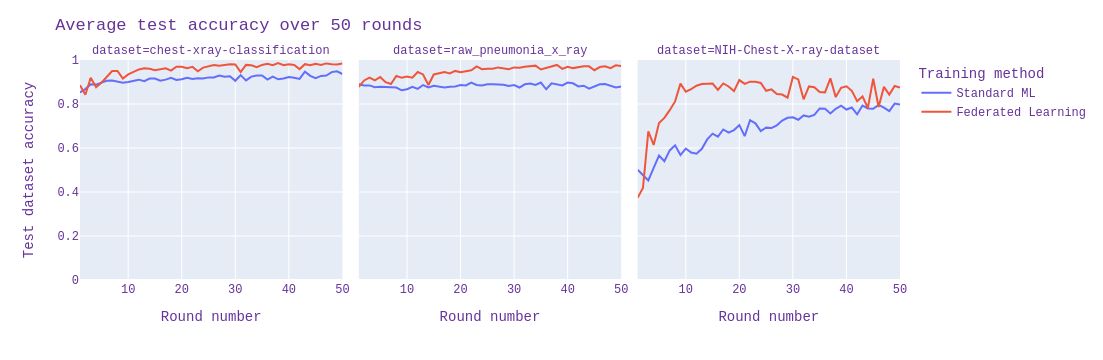

In [50]:
import plotly.express as px

# obtained from executing using Covalent and federated learning for 50 rounds
df_ind = pd.read_csv("assets/individual_test_accuracies.csv")

# obtained from executing without federated learning for 50 rounds independently
df_fed = pd.read_csv("assets/federated_test_accuracies.csv")

df = pd.concat([df_ind, df_fed], axis=0)


ds_mapping = {
    "('keremberke/chest-xray-classification', 'full')":
        "chest-xray-classification",
    "('mmenendezg/raw_pneumonia_x_ray',)": "raw_pneumonia_x_ray",
    "('alkzar90/NIH-Chest-X-ray-dataset', 'image-classification')":
        "NIH-Chest-X-ray-dataset",
}
df['dataset'] = df['dataset'].apply(
    lambda x: ds_mapping[x]
)
method_mapping = {
    "individual": "Standard ML",
    "federated": "Federated Learning",
}
df['method'] = df['method'].apply(
    lambda x: method_mapping[x]
)

fig = px.line(
    df, x="round", y="test_accuracy",
    facet_col="dataset", color="method",
)

fig.update_layout(
    title="Average test accuracy over 50 rounds",
    xaxis_title="Round number",
    xaxis_range=[1, 50],
    yaxis_range=[0, 1],
    xaxis2_title="Round number",
    xaxis3_title="Round number",
    yaxis_title="Test dataset accuracy",
    legend_title="Training method",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

In an attempt to comprehend the reasons behind the federated model performance, we generate feature maps using the convolutional layer for separate models (upper row) and the federated learning model (lower row). The visual representations offer insights into the evolution of specialized and distinct filters by individual classifiers, whereas the federated model illustrates traits that span across all individual models.

![alt text](assets/feature_visualization.png)

# Conclusion
Leveraging Covalent, we established a federated learning framework across three cloud computing resources while maintaining strict data isolation protocols. This allowed us to build an X-ray pneumonia classifier seamlessly by utilizing dynamic sublattices for on-the-fly allocation of compute resources, even with heterogeneous datasets.

The Covalent-enabled design of the federated learning experiment simplifies adding datasets, adjusting training hyperparameters, and altering aggregation technique. The workflow ensures reproducibility with secure metadata storage in a scalable database.
This blog post aims to showcase the remarkable potential of Covalent in conjunction with various resources such as AWS Batch, Azure Batch, and GCP Batch. 

[Covalent](https://github.com/AgnostiqHQ/covalent/) is free and [open source](https://www.covalent.xyz/open-source/). Please visit the Covalent documentation for more information and many more tutorials. 